# Load data

In [136]:
import os
import datetime
import pandas as pd
import seaborn as sns
import opendatasets as od

import torch

from sklearn.model_selection import train_test_split

In [122]:
if 'flight-delay-and-cancellation-dataset-2019-2023' not in os.listdir():
    dataset = 'https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023'
    od.download(dataset)

In [123]:
selected_columns = ['FL_DATE', 'AIRLINE_CODE', 'FL_NUMBER', 'CRS_DEP_TIME', 'DISTANCE', 'CANCELLED']

In [124]:
df = pd.read_csv('./flight-delay-and-cancellation-dataset-2019-2023/flights_sample_3m.csv', usecols=selected_columns)
df

,FL_DATE,AIRLINE_CODE,FL_NUMBER,CRS_DEP_TIME,CANCELLED,DISTANCE
0,2019-01-09,UA,1562,1155,0.0,1065.0
1,2022-11-19,DL,1149,2120,0.0,1399.0
2,2022-07-22,UA,459,954,0.0,680.0
3,2023-03-06,DL,2295,1609,0.0,1589.0
4,2020-02-23,NK,407,1840,0.0,985.0
...,...,...,...,...,...,...
2999995,2022-11-13,AA,1522,1742,0.0,328.0
2999996,2022-11-02,AA,1535,1300,0.0,977.0
2999997,2022-09-11,DL,2745,534,0.0,151.0
2999998,2019-11-13,YX,6134,1600,0.0,184.0


### preprocess data

In [125]:
def preprocess_df(df):
    df = pd.get_dummies(df, columns=['AIRLINE_CODE'], dtype=int)
    
    print(f'before duplicates: {len(df)}')
    df.drop_duplicates(inplace=True)
    print(f'after drop duplicates {len(df)}')

    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    df['YEAR'] = df['FL_DATE'].dt.year
    df['MONTH'] = df['FL_DATE'].dt.month
    df['WEEK'] = df['FL_DATE'].dt.weekday
    df['DAY'] = df['FL_DATE'].dt.day

    df = df.sort_values(by='FL_DATE').reset_index()
    df = df.drop(columns='index')
    df['FL_DATE'] = df['FL_DATE'].apply(datetime.datetime.toordinal)
    
    return df

In [126]:
df = preprocess_df(df)

before duplicates: 3000000
after drop duplicates 3000000


In [127]:
df

,FL_DATE,FL_NUMBER,CRS_DEP_TIME,CANCELLED,DISTANCE,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,...,AIRLINE_CODE_OO,AIRLINE_CODE_QX,AIRLINE_CODE_UA,AIRLINE_CODE_WN,AIRLINE_CODE_YV,AIRLINE_CODE_YX,YEAR,MONTH,WEEK,DAY
0,737060,1527,1354,0.0,937.0,0,0,0,1,0,...,0,0,0,0,0,0,2019,1,1,1
1,737060,1265,1910,0.0,612.0,0,0,0,0,0,...,0,0,0,1,0,0,2019,1,1,1
2,737060,1409,600,0.0,689.0,0,0,0,0,1,...,0,0,0,0,0,0,2019,1,1,1
3,737060,2346,1023,0.0,1062.0,0,0,0,0,0,...,0,0,1,0,0,0,2019,1,1,1
4,737060,1780,1601,0.0,971.0,0,0,0,0,0,...,0,0,0,0,0,0,2019,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,738763,1746,1815,0.0,728.0,0,0,0,1,0,...,0,0,0,0,0,0,2023,8,3,31
2999996,738763,642,2020,0.0,1024.0,0,0,1,0,0,...,0,0,0,0,0,0,2023,8,3,31
2999997,738763,1244,945,0.0,628.0,0,0,0,0,0,...,0,0,0,0,0,0,2023,8,3,31
2999998,738763,2409,800,0.0,997.0,0,0,0,0,0,...,0,0,1,0,0,0,2023,8,3,31


<Axes: >

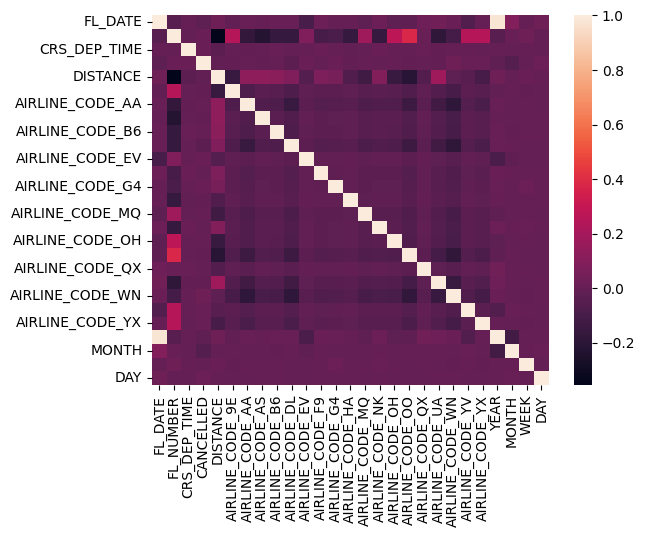

In [128]:
sns.heatmap(df.corr(method='spearman'))

In [131]:
X = df.drop(columns='CANCELLED')
y = df['CANCELLED']

In [149]:
def get_dataset(X: pd.DataFrame, y: pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train, X_test = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train.to_numpy(), X_test.to_numpy())]
    y_train, y_test = [torch.tensor(arr, dtype=torch.float32) for arr in (y_train.to_numpy(), y_test.to_numpy())]

    train_DS, test_DS = torch.utils.data.TensorDataset(X_train, y_train),\
                        torch.utils.data.TensorDataset(X_test, y_test)
    
    return train_DS, test_DS

In [151]:
train_DS, test_DS = get_dataset(X, y)

In [152]:
next(iter(train_DS))

(tensor([7.3706e+05, 1.5270e+03, 1.3540e+03, 9.3700e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0190e+03, 1.0000e+00,
         1.0000e+00, 1.0000e+00]),
 tensor(0.))

In [153]:
next(iter(test_DS))

(tensor([7.3845e+05, 3.3800e+02, 6.0500e+02, 6.9600e+02, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0220e+03, 1.0000e+01,
         2.0000e+00, 1.9000e+01]),
 tensor(0.))